<a href="https://colab.research.google.com/github/Nitinyad/LLM-from-scratch/blob/main/Simplified_attention_mechanism_ch02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Implementing a simplified attention mechanism

input sentence , which already been embedding into 3-dim vectors.


In [13]:
import torch
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
    [0.55, 0.87, 0.66], # journey  (x^2)
    [0.57, 0.85, 0.64], # starts    (x^3)
    [0.22, 0.58, 0.33], # with      (x^4)
    [0.77, 0.25, 0.10], # one       (x^5)
    [0.05, 0.80, 0.55]] # step      (x^6)
)
print(inputs.shape)

torch.Size([6, 3])


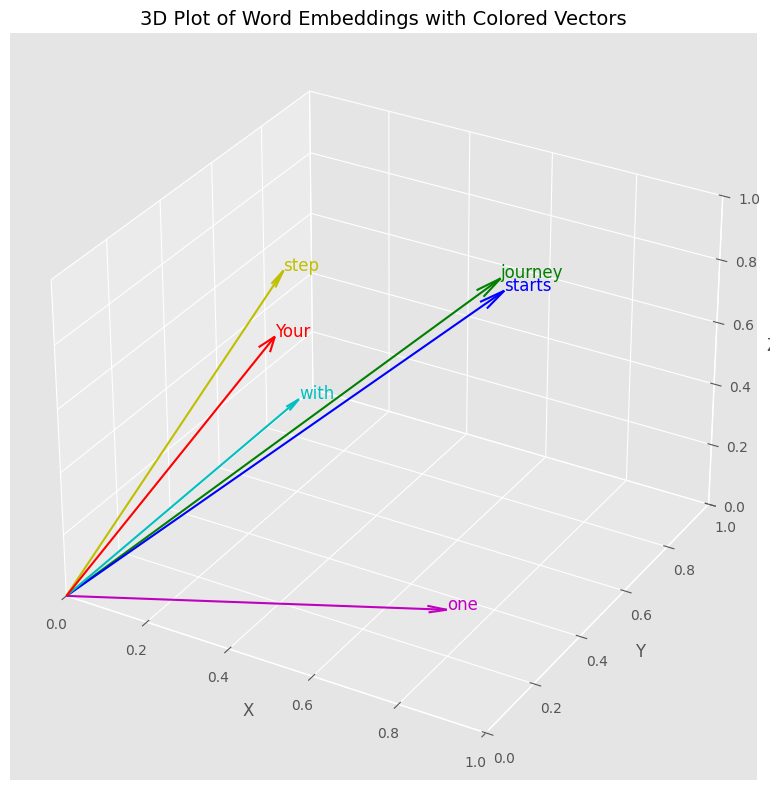

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use("ggplot")

words = ['Your', 'journey', 'starts', 'with', 'one', 'step']

if isinstance(inputs, torch.Tensor):
    x_coords = inputs[:, 0].numpy()
    y_coords = inputs[:, 1].numpy()
    z_coords = inputs[:, 2].numpy()
else:
    x_coords = inputs[:, 0]
    y_coords = inputs[:, 1]
    z_coords = inputs[:, 2]

# 🔵 Increased plot size
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['r', 'g', 'b', 'c', 'm', 'y']

for (x, y, z, word, color) in zip(x_coords, y_coords, z_coords, words, colors):
    ax.quiver(0, 0, 0, x, y, z, color=color, arrow_length_ratio=0.05)
    ax.text(x, y, z, word, fontsize=12, color=color)

ax.set_xlabel('X', fontsize=12)
ax.set_ylabel('Y', fontsize=12)
ax.set_zlabel('Z', fontsize=12)

ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])

plt.title('3D Plot of Word Embeddings with Colored Vectors', fontsize=14)
plt.tight_layout()
plt.show()

Each row represents a word , and each column represents an embedding dimension ,
the second input token serves as the query .

In [4]:
query = inputs[1]#we are taking jounary as an query
attn_scores_2 = torch.empty(inputs.shape[0])
for i , x in enumerate(inputs):
  attn_scores_2[i] = torch.dot(x , query)

print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


In [5]:
## after the dot we need to normalise this to maintain numerical stability and improve learning dynamics
## making all the values from 0 to 1

attn_weights_2_temp = attn_scores_2 / attn_scores_2.sum()
print("attention weights : " , attn_weights_2_temp)

print("sum : " , attn_weights_2_temp.sum())

attention weights :  tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
sum :  tensor(1.0000)


it's more common and advisable to use the softmax function to normalisation ,
This approach is better at managing extreme values and offers more favorable gradient properties during training.

below is a basic implementation of softmax function for normalizing the attention scores :

In [6]:
def softmax_naive(x):
  return torch.exp(x) / torch.exp(x).sum(dim = 0)

attn_weights_2_naive = softmax_naive(attn_scores_2)
print("attention weights : " , attn_weights_2_naive)

print("sum : " , attn_weights_2_naive.sum())

attention weights :  tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
sum :  tensor(1.)


we are able to make this interpretable statements only because we converted the attention scores to attention weights.
because attention weights are sum up to 1 , we can make the interpretable statements like "Your" pay only 10% attention to the word "journey" like these statements.

In [7]:
attn_weights_2_naive = torch.softmax(attn_scores_2 , dim = 0)
print("attention weights : " , attn_weights_2_naive)

print("sum : " , attn_weights_2_naive.sum())

attention weights :  tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
sum :  tensor(1.)


As the output shows, the softmax function also meets the objective and normalizes the attention weights such that they sum to 1:

In addition, the softmax function ensures that the attention weights are always positive. This makes the output interpretable as probabilities or relative importance, where higher weights indicate greater importance.

The context vector (z2) is calculated as a weighted sum of all input vectors.
This involves multiplying each input vector to the attention weights we have caculated .

In [9]:
query = inputs[1]

context_vec2 = torch.zeros(query.shape)
for i , x in enumerate(inputs):
  context_vec2 += attn_weights_2_naive[i] * x

print(context_vec2)

tensor([0.4419, 0.6515, 0.5683])


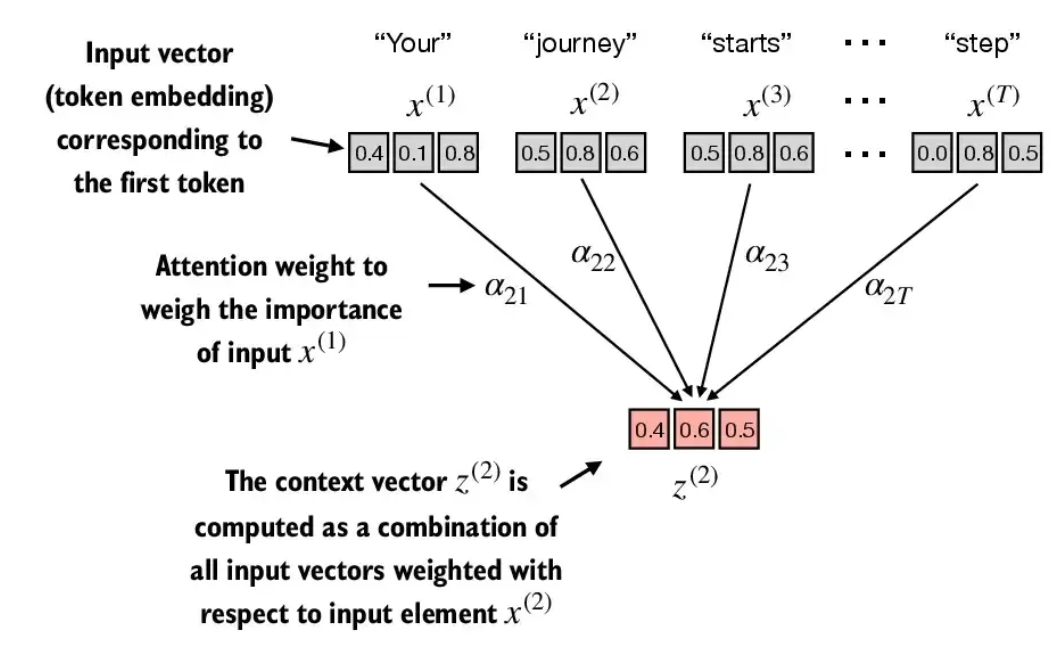

Now , we can extend this computation to calculate attention weights and context vectors for all inputs.

First ,we add an additional for-loop to compute the dot products for all pairs of inputs.

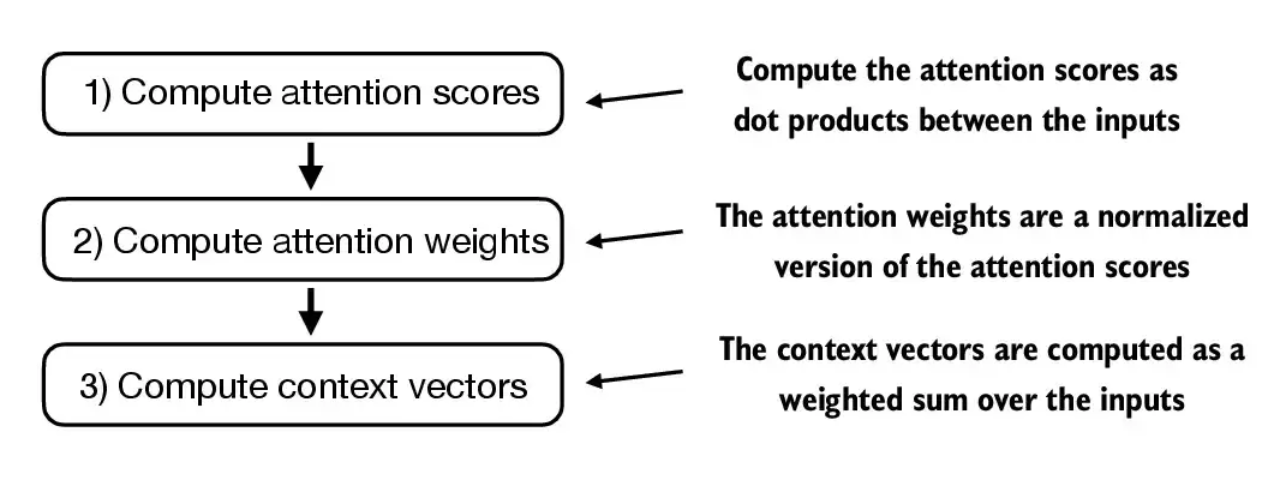

In [11]:
#so we follow 3 step as before:
attn_scores = torch.empty(6 , 6)

for i , x_i in enumerate(inputs):
  for j, x_j in enumerate(inputs):
    attn_scores[i , j] = torch.dot(x_i , x_j)
#so we can get the attention scores for all the inputs embeddings;


print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


each element in the preceding tensor represents an attention score between each pair of inputs.

when computing the preceding attention score tensor , we used for-loop in python.

so, this for-loops are slow , and we can acheive the same using the matrix multiplication.

In [12]:
attn_scores = inputs @ inputs.T # multiplication of inputs and transpose of inputs
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


Now we can normalise each row so that the values in each row sum to 1.

 understanding the softmax function pytorch

In [ ]:
import torch

x = torch.randn(2 , 3 , 2)
# 2 element along the first dimension , 3 element along with the second dimension , 2 element
#along with third dimension
print(x)

tensor([[[ 0.0805, -0.1080],
         [-0.4042, -0.2495],
         [ 0.6560,  0.2934]],

        [[-0.8752,  0.5093],
         [ 0.1834, -2.2981],
         [ 1.5602,  1.9560]]])


In [ ]:
output1 = torch.nn.functional.softmax(x, dim = 0)

print(output1)

tensor([[[0.7223, 0.3504],
         [0.3572, 0.8858],
         [0.2882, 0.1594]],

        [[0.2777, 0.6496],
         [0.6428, 0.1142],
         [0.7118, 0.8406]]])


In [ ]:
output1 = torch.nn.functional.softmax(x, dim = 1)

print(output1)

tensor([[[0.2947, 0.2974],
         [0.1815, 0.2582],
         [0.5239, 0.4444]],

        [[0.0653, 0.1883],
         [0.1884, 0.0114],
         [0.7463, 0.8003]]])


In [ ]:
output1 = torch.nn.functional.softmax(x, dim = 2)

print(output1)

tensor([[[0.5470, 0.4530],
         [0.4614, 0.5386],
         [0.5897, 0.4103]],

        [[0.2003, 0.7997],
         [0.9228, 0.0772],
         [0.4023, 0.5977]]])


In [ ]:
output1 = torch.nn.functional.softmax(x, dim = -1)

print(output1)

tensor([[[0.5470, 0.4530],
         [0.4614, 0.5386],
         [0.5897, 0.4103]],

        [[0.2003, 0.7997],
         [0.9228, 0.0772],
         [0.4023, 0.5977]]])


now apply softmax to attn_scores

In [14]:
attn_weights = torch.softmax(attn_scores , dim = -1)
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


in the context of using pytorch , the dim parameter in functions like torch.softmax specifies the dimension of the input tensor along which the function will be computed.

By setting dim = -1 , we are instructing the softmax function to apply the normalisation along with the dimension of attn_scores tensor.

if the attn_scores is a 2d tensor (for example with a shape of [rows , columns]) , dim = -1 will normalise across the columns so that the values in each row(summing over the column dimension) sum up to 1 .

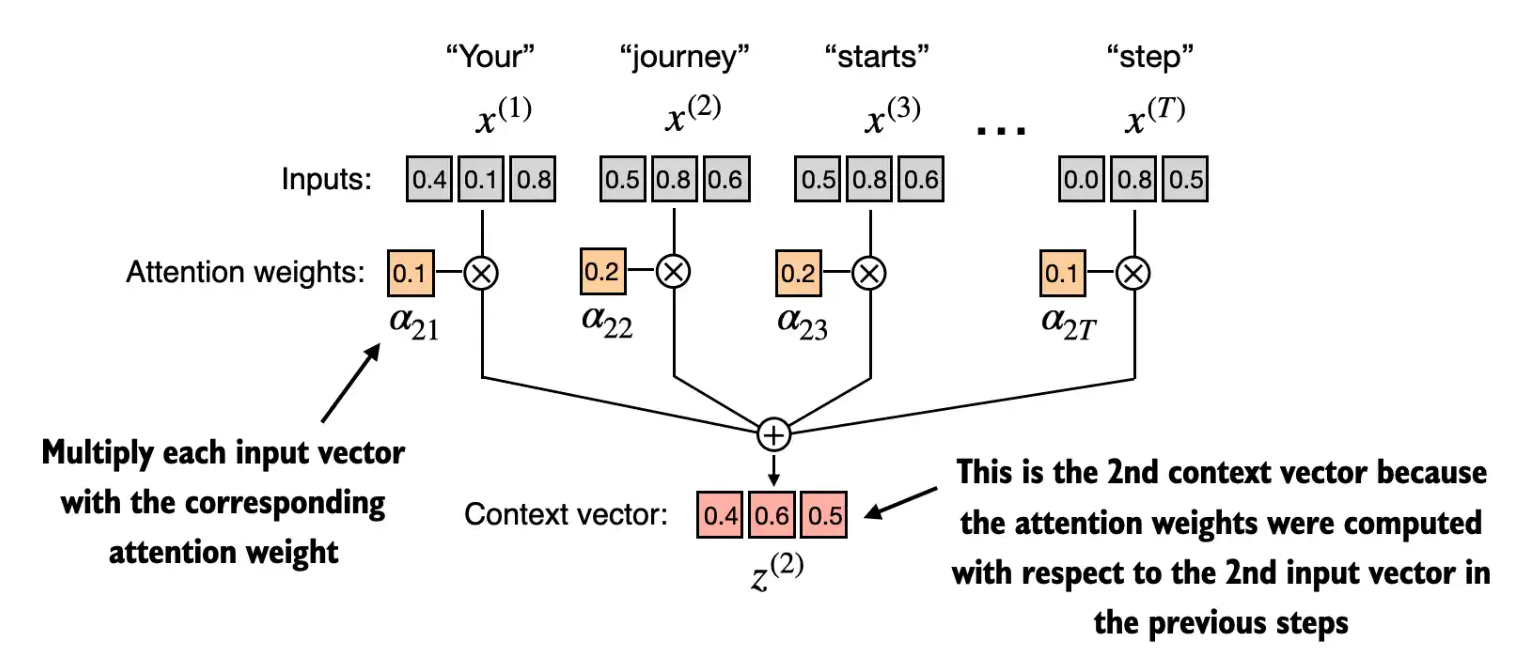

In [ ]:
 import torch
 import torch.nn as nn
 import torch.nn.functional as F


In [ ]:
class Attention(nn.Module):
  def __init__(self , d_in , d_out):
    super().__init__()
    self.d_in = d_in
    self.d_out = d_out
    self.Q = nn.Linear(d_in , d_out)
    self.K = nn.Linear(d_in , d_out)
    self.V = nn.Linear(d_in , d_out)
  def forward(self, x):
    queries = self.Q(x)
    keys = self.K(x)
    values = self.V(x)
    scores = torch.bmm(queries , keys.transpose(1 , 2))
    scores = scores/(self.d_out ** 0.5)
    attention = F.softmax(scores , dim = 2)
    hidden_states = torch.bmm(attention , values)
    return hidden_states

In [ ]:
SOS_token = 0
EOS_token = 1

index2words = {
    SOS_token : 'SOS',
    EOS_token : 'EOS'
}

words = "How are you doing ? I am good and you ?"
words_list = set(words.lower().split(' '))
for word in words_list:
  index2words[len(index2words)] = word
index2words

{0: 'SOS',
 1: 'EOS',
 2: 'are',
 3: 'you',
 4: 'how',
 5: 'and',
 6: 'good',
 7: 'am',
 8: 'doing',
 9: '?',
 10: 'i'}

In [ ]:
word2index = {w : i for  i , w in index2words.items()}
word2index

{'SOS': 0,
 'EOS': 1,
 'are': 2,
 'you': 3,
 'how': 4,
 'and': 5,
 'good': 6,
 'am': 7,
 'doing': 8,
 '?': 9,
 'i': 10}

In [ ]:
def convert2tensors(sentence):
  words_list = sentence.lower().split(' ')
  indexes = [word2index[word] for word in words_list]
  return torch.tensor(indexes, dtype=torch.long).view(-1, 1)


sentence = "How are you doing ?"
indexes = convert2tensors(sentence)

indexes.size()

torch.Size([5, 1])

In [ ]:
#now , create a neural network
HIDDEN_SIZE = 10
VOCAB_SIZE = len(word2index)

embedding = nn.Embedding(VOCAB_SIZE , HIDDEN_SIZE)
attention = Attention(HIDDEN_SIZE , HIDDEN_SIZE)

sentence = "How are you doing ?"
input_tensor = convert2tensors(sentence)
embedded = embedding(input_tensor)
embedded

tensor([[[ 0.8495,  0.3864, -0.5278,  0.4720, -1.4200, -2.1962, -0.3251,
          -0.4266, -0.3471,  0.2764]],

        [[-1.0950,  0.7938,  1.6516,  0.1580, -0.2781,  2.0376,  0.7110,
           0.9433,  0.3296,  0.8694]],

        [[-0.7900,  0.1646,  0.5789,  0.3503,  0.3344,  1.3398,  0.4964,
           0.9351,  0.7707, -0.6385]],

        [[-0.3895, -0.1184,  0.1261,  0.0411,  0.8719,  0.4642, -0.9111,
           0.3526,  0.4827, -0.3697]],

        [[-0.8784,  1.4271,  0.1116, -1.0963, -0.9959,  0.0584, -2.0526,
          -0.9140, -0.8722, -0.0905]]], grad_fn=<EmbeddingBackward0>)

In [ ]:
hidden_states = attention(embedded)
hidden_states

tensor([[[-0.3682,  0.6685, -0.3468, -0.4094,  0.2285,  0.0578, -0.3448,
           0.2247,  0.1158, -0.6932]],

        [[ 0.7111, -0.1532,  1.6342,  0.0558, -0.3436, -0.5602,  0.9956,
          -0.3218,  0.4157, -0.2268]],

        [[ 0.2816, -0.1398,  0.7088,  0.0611, -0.2454, -0.1630,  0.1055,
          -0.3213,  0.2680,  0.1117]],

        [[ 0.3011, -0.1501, -0.0969, -0.0042, -0.1763,  0.2279, -0.0565,
           0.1917,  0.5505,  0.0942]],

        [[ 0.0279,  0.6651,  0.1942, -0.0236, -0.7778, -0.9810,  0.1080,
           1.3085,  1.0830, -0.6574]]], grad_fn=<BmmBackward0>)

In [ ]:
d_in = HIDDEN_SIZE
d_out = HIDDEN_SIZE
Q = nn.Linear(d_in , d_out)
K = nn.Linear(d_in , d_out)
V = nn.Linear(d_in , d_out)

In [ ]:
queries = Q(embedded)
keys = K(embedded)
values = V(embedded)

In [ ]:
queries.size()

torch.Size([5, 1, 10])

In [ ]:
keys

tensor([[[-0.3648,  0.0951, -0.0340,  0.1934,  0.6354, -0.5180,  0.5161,
          -0.1698,  0.1213, -0.4717]],

        [[ 0.2027, -0.8654, -0.4392,  0.6561, -1.5619,  0.7815, -0.0881,
           0.8237,  0.6591,  0.1944]],

        [[-0.2460, -0.2154,  0.0308,  0.6013, -0.6138,  0.5294,  0.3444,
          -0.1761, -0.2527,  0.4552]],

        [[-0.0230,  0.1790, -0.4573,  0.0415, -0.0922,  0.3702,  0.3473,
          -0.3443, -0.2614,  0.5960]],

        [[ 1.1482, -0.5691, -1.4520,  0.7879, -0.3952,  0.6095,  0.2572,
           0.2591,  0.7977,  0.5548]]], grad_fn=<ViewBackward0>)

In [ ]:
keys.size()

torch.Size([5, 1, 10])

In [ ]:
scores = torch.bmm(queries , keys.transpose(1,2))
scores.size()

torch.Size([5, 1, 1])

In [ ]:
scores = scores / (d_out ** 0.5)
attention = F.softmax(scores , dim = 2)

#softmax transformation is just a map from scroces to probability scores


In [ ]:
attention

tensor([[[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]]], grad_fn=<SoftmaxBackward0>)

In [ ]:
hidden_states = torch.bmm(attention , values)
hidden_states.size()

torch.Size([5, 1, 10])